# Calibrating the Liquid Drop Model

The purpose of this challenge is for you to calibrate the Liquid Drop Model https://en.wikipedia.org/wiki/Semi-empirical_mass_formula and compare the results of a "black box" calibration vs a principled Bayesian one.

Your task is to:

- Import the data from the AME 2016 table (included in the github). We are only using nuclei above A=16 to avoid light nuclei where the LDM fails particularly. Perform a curve fit using the built in functions from python (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and take note of the reported uncertainties in the parameters. 
- Make a plot of the residuals and estimate the model error on its best fit. 
- Make a model calibration using the Bayesian formalism we defined and a Metropolis sampler. For the error, use your estimation from the previous point (the model error in this case is much smaller than the actual experimental uncertainties). 
- Plot the corner plot posterior as well as the model values on the Binding Energy per nucleon for the Calcium chain up to 60Ca including the available experimental data.
- What would be the results if you have used in the calibration the Binding Energy per nucleon instead of the total Binding Energy?
- Bonus: Find the experimental error in the masses and repeat the calibration using only experimental errors. This should give a good demonstration on the dangers of not taking into account model errors. 


In [2]:
%pip install corner
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy

#Some pretty colors I like
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

Note: you may need to restart the kernel to use updated packages.


In [5]:
def LDM(x, *params):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    
    n=x[0]
    z=x[1]
    
    return params[0]*(n+z) - params[1]*(n+z)**(2/3) - params[2]*((n-z)**2/(n+z)) - params[3]*((z**2)/((n+z)**(1/3)))

- Import the data from the AME 2016 table (included in the github). We are only using nuclei above A=16 to avoid light nuclei where the LDM fails particularly. Perform a curve fit using the built in functions from python (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and take note of the reported uncertainties in the parameters. 


In [6]:
from scipy.optimize import curve_fit
data = np.loadtxt('Masses2016.txt', skiprows=1)

xdata = np.array([data[:,0], data[:,1]])
ydata = np.array(data[:,2])
p0 = np.array([1,1,1,1])
ans, cov = curve_fit(LDM, xdata, ydata, p0=p0)
ans


array([10.4618677 , 14.24325763,  5.40685517,  0.49088531])

Make a plot of the residuals and estimate the model error on its best fit. 

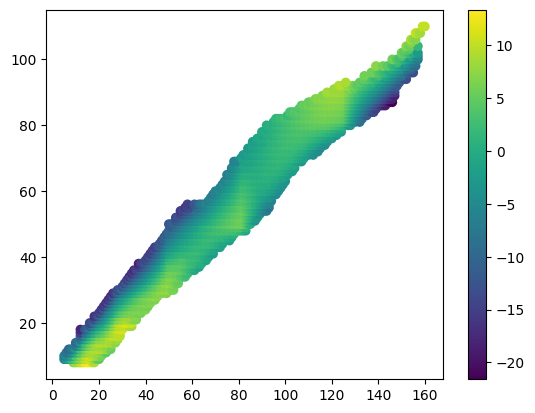

In [9]:
yNew = LDM(xdata, *ans)
residuals = ydata - yNew

plt.scatter(data[:,0],data[:,1] , c=residuals)
plt.colorbar()
plt.show()

In [15]:
std_dev = np.sqrt(np.diag(cov))
print("Parameter Standard deviation: ", std_dev)

Parameter Standard deviation:  [0.04256066 0.13210826 0.10602011 0.00297797]


In [13]:
# Find Model Errors
errors = np.sqrt(np.sum(residuals**2))
print("Model Error:", errors)


Model Error: 276.3584829725343


Make a model calibration using the Bayesian formalism we defined and a Metropolis sampler. For the error, use your estimation from the previous point (the model error in this case is much smaller than the actual experimental uncertainties). 

In [ ]:
# Define the likelihood function for given errors sigma
def likelihood(x, params):
#Assumed format for data=[xvals,yvals]
    data, model, sigmas = params
    likelihood_log_val=0

    pre = np.sqrt(2*np.pi*sig**2)  
    chisq = -1/2*((data[1][i] - model(data[0][i],params)) / sigmas[i])**2\
        -np.log(2*np.pi*sigmas[i]**2)/2
        
    return np.exp(likelihood_log_val)

# Define the prior function
def prior_model_A(params_vals,arguments):
    params0,params0_Cov_Inv_matrix=arguments
    mu=np.array(params_vals)-np.array(params0)
    params_size=len(params_vals)
    return (2*np.pi)**(-params_size/2)*np.linalg.det(params0_Cov_Inv_matrix)**(-1)*np.exp(-np.dot(mu,np.dot(params0_Cov_Inv_matrix,mu))/2)



In [ ]:
# Define the Metropolis algorithm
def metropolis(data,sigma, prior,prior_arguments, likelihood,model,\
               num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model
    likelihood_arguments=[data, model, sigma]
    initial_parameters=prior_arguments[0]
    #thermalizing
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    
    posterior_current=(likelihood(params_current,likelihood_arguments))*(prior(params_current,\
                                                                               prior_arguments))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*(prior(params_proposed,\
                                                                               prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*\
        (prior(params_proposed,prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(posterior_current)
        
    
    #Rule of thumb acceptance is around 50%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)

